## 1. 필요한 라이브러리들을 불러온다

In [1]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
from itertools import count


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. 예제 데이터를 생성한다

어떤 품질 (Property, y)을 Setting한 Point에 맞추기 위해 온도 (Temperature, x)를 어떻게 운전해야하나?를 취적화 하는 것을 목적으로 하는 상황이며, x와 y는 아주 강한 선형성을 띈다고 가정한다.

아래 생성한 데이터는 "그동안 temperature (x)를 이런식으로 운전했을 때, 제품의 품질 (y)는 이랬다"라는 데이터라고 이해하면 된다.

아래 그래프로 시각화 하였을 때, 온도(x)가 높을 수록 품질(y)는 상승한다. 

In [35]:
# 예제 데이터 생성 
import pandas as pd 
temp = [random.randint(-10,100) for _ in range(100)]
property = [i*3.5 + 10 + random.random()*2 for i in temp]
# property = [math.sin(math.pi * (i*10 / 180)) for i in temp]

data = pd.DataFrame({
    'x': temp,
    'y':property
    })

In [36]:
data.head()

,x,y
0,41,153.622622
1,-6,-9.897396
2,50,185.660192
3,25,97.922067
4,25,98.492088


<Axes: xlabel='x', ylabel='y'>

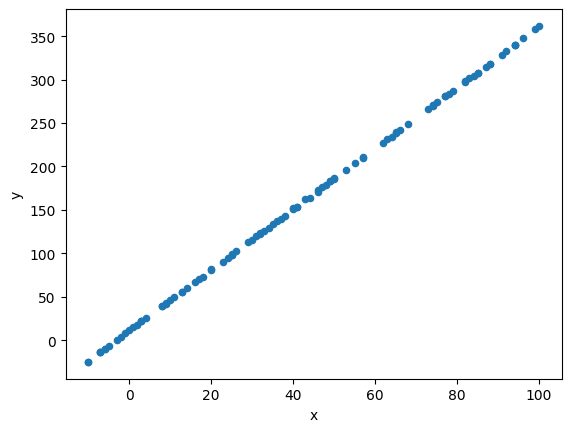

In [37]:
data.plot(x='x', y='y', kind='scatter')

## 3. Environment 정의

episode를 스스로 생성하기 위한 state, reward, action 등 environment를 정의한다. 

상황을 개발자가 원하는대로 정의하면 되지만, 공정의 경우 모든 episode 상황에 대한 결과가 어떨지 실제로 실험해보기에는 현실적으로 불가능에 가깝다.

따라서, 관심있는 공정에서 x값이 ~할때, y값이 어떨지를 추정할 수 있는 x와 y의 Model이 필요하다.

애초에 선형성이 강한 가상의 환경을 정의했으므로 Linear Regression 모델을 생성한다. 

(당연히 x와 y의 Linear Regression 모델을 알고 있다면 y값을 어떤 setting point로 만들기 위해 x를 어떤 값으로 해야할지는 굳이 강화학습과 같은 최적화 알고리즘을 하지 않아도 쉽게 계산이 가능하다. 그러나, 지금은 최대한 단순한 가상의 환경을 가정하여 진행한다.)

In [38]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

hist = model.fit(np.array(temp).reshape(-1,1), np.array(property).reshape(-1,1))

print(hist.coef_)

[[3.4995349]]


In [39]:
model.score(np.array(temp).reshape(-1,1), np.array(property).reshape(-1,1))

0.9999716801278229

model의 coef를 확인해보면 3.5에 근접한다. 애초에 x*3.5로 y를 만들었으니 그럴 수 밖에 없다. 학습이 아주 잘되었다.

이제 위에서 생성한 모델을 기반으로 Environment Class를 정의한다. 

Environment Class에는 생성자 외에 세 개 function이 필요하다.

In [32]:
class Environment:
    def __init__(self, z, setPoint):
        self.z = z 
        self.setPoint = setPoint 
        self.terminated = False 
        self.state = None 
        
    def reset(self):
        self.yPred = model.predict(np.array([self.z]).reshape(-1,1)).item()
        self.state = torch.tensor([self.setPoint - self.yPred])
        #self.state = torch.tensor(self.state, dtype=torch.float32, device=device).unsqueeze(0)
        return self.state 
    
    def step(self, action):
        if action == 0:
            self.z -= 1
        elif action == 1:
            self.z += 1
        
        if self.z < -10 or self.z > 100:
            reward = -100. 
            self.terminated = True 
            return None, torch.tensor([reward]), self.terminated 
        
        self.yPred = model.predict(np.array([self.z]).reshape(-1,1)).item()
        self.state = torch.tensor([self.setPoint - self.yPred])
        #self.state = torch.tensor(self.state, dtype=torch.float32, device=device).unsqueeze(0)
        if abs(self.state) <= 5:
            self.terminated = True 
        reward = 1 / abs(self.state) * 5
        return self.state, reward, self.terminated 
    
    def render(self):
        return self.z, round(self.yPred,2)

먼저 생성자를 보면 z와 setPoint를 초기값으로 받는다, z는 현재 x값을 의미하고 setPoint는 y값을 어떤 값으로 Setting하고 싶은지에 대한 값을 의미한다. 


**reset()** 은 매 episode마다 맨 처음 state를 reset하는 역할을 수행한다. 가능한 범위 내 random한 가상의 state 값을 return한다.

state는 (setPoint - y)값으로 한다.

첫, 이 state를 최소화하는 것이 목적이다.
 
**step()** 은 action을 input으로 받아 현 state에서 action을 취한 다음 'state, reward, 종료인지 아니지'에 대한 정보를 return한다.

본 과정에서 action은 0과 1로 정의한다.
action이 0이면 x를 1만큼 낮추고, action이 1이면 x를 1만큼 키운다.

reward는 1/abs(setPoint - y)로 정의한다.
setting한 값과 현재 y값과의 차이가 작을수록 큰 reward를 발리한다.

**y는 위에서 생성한 모델에 x를 넣어 prediction하여 계산한다. 이 과정을 위해 x와 y의 model을 만들었다고 이해하면 된다.**

abs(setPoint - y)값이 5보다 작으면 최적화 되었다고 판단하여 episode를 종료한다.

또한, action을 취한 후 x가 정의한 min ~ max range를 벗어나면 -100의 reward로 return하며 episode는 종료된다.

**render()** 는 episode가 어떻게 진행되고 있는지 과정을 확인하기 위한 function으로, 꼭 필요한 function은 아니며 원하는 부분을 자유롭게 구현하면 된다. 여기서는 현재 x (z) 값을 return하도록 구현하였다.

이렇듯 'state, action, reward, episode terminate 조건' 등 모든 환경의 상황과 최대한 유사하게, 효율적으로 모델이 최적화 할 수 있도록 정의되어야 하며 이 과정에는 Biz.domain이 필요하다.

## 4. Reinforcement Model 정의

정의한 가상환경이 굉장히 단순하므로 Reinforcement Model도 아주 단순하게 구현한다.

현 state를 입력받아 최적의 action을 return하는 역할을 한다. 

In [8]:
class DQN(nn.Module):
    def __init__(self, outputs):
        super(DQN, self).__init__()
        self.linear1 = nn.Linear(1, 16, bias=True)
        self.linear2 = nn.Linear(16, outputs, bias=True)
        
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return torch.unsqueeze(F.log_softmax(x, dim=0), 0)

## 5. Select Action 정의

바로 위에서 정의한 reinforcement model에 기반하여 현 state를 입력으로 받아 다음 action을 return하는 function을 정의한다. 

In [9]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10


In [10]:
n_actions = 2  # action 갯수
policy_net = DQN(n_actions).to(device)
target_net = DQN(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [11]:
steps_done = 0
def select_action(state):
    global steps_done 
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1]
    else:
        return torch.tensor([random.randrange(n_actions)], device=device, dtype=torch.long)

policy network에 의해서만 action을 취하다보면 local minimum에 빠질 수 있으므로 가끔 random한 선택을 하게 해준다.

eps_threshold가 random한 어떤 값보다 작으면 policy network가 return한 action을 return하고, random한 어떤 값보다 크면 random한 action을 return한다.

## 6. Traning

이제 위에서 만든 모든 것들을 조합하여 학습을 진행한다.

먼저 학습할 episode들을 저장할 memory를 정의한다.

In [12]:
from collections import deque, namedtuple

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """transition 저장"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)



optimize function도 정의한다.

이 부분은 강화학습 Q-Learning을 이해하고 있어야 이해할 수 있다.

In [13]:
optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

In [14]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return 
    
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.stack(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    state_action_values = policy_net(state_batch).squeeze().gather(1, action_batch.unsqueeze(1))
    
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states.reshape(non_final_next_states.size()[0],1)).squeeze().max(1)[0].detach()
    
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1,1)
    optimizer.step()
    
    return loss.item()
    

In [15]:
def Action(x):
    if x.item() == 0:
        return "Down"
    else:
        return "Up"

이제 실제 episode를 진행하면서 강화학습 모델을 학습한다.

In [16]:

success_cnt = 0
fail_cnt = 0
num_episodes = 100

for i_episode in range(num_episodes):
    epMemory = list()
    z = random.randrange(-10, 100)
    setPoint = random.randrange(math.floor(min(data['y'])), math.ceil(max(data['y'])))
    env = Environment(z=z, setPoint=setPoint)
    state = env.reset()
    print("setPoint (특정 y값):", setPoint, "을 맞추기위해 위해")
    for t in count():
        # 행동 결정
        action = select_action(torch.tensor([state]).float())
        next_state, reward, done = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        
        # 메모리에 경험 저장
        epMemory.append([state, action, next_state, reward])
        
        # 다음 상태로 이동
        state = next_state
        
        loss = optimize_model()
        
        msg = f"Episode: {i_episode}/{t} - Action 이후 x값과 예측 y값: {env.render()} / 수행 action: {Action(action)} / 다음상태 y 값: {next_state} / reward: {round(reward.item(),2)}"
        # print(msg)
        # print('loss:',loss)
        
        if done:
            print(msg)
            print('loss:',loss)

            cur_x,pred = env.render()
            if -10 <= cur_x <= 100:
                success_cnt+=1
                _ = [memory.push(epMemory[i][0], epMemory[i][1], epMemory[i][2], epMemory[i][3]) for i in range(len(epMemory))]
                print(f"성공! {success_cnt} / {success_cnt+fail_cnt}")
                
            else:
                fail_cnt += 1
                print(f"실패! {fail_cnt} / {success_cnt+fail_cnt}")
            print("")
            break

        if t >= 10000:
            print("중단!")
            break
        
    # 주기적 네트워크 업데이트, 타겟 네트워크 업데이트  
    if i_episode % TARGET_UPDATE == 0:  # 10번에 한버씩 
        target_net.load_state_dict(policy_net.state_dict())

print(f"Complete {success_cnt}")

setPoint (특정 y값): 272 을 맞추기위해 위해
Episode: 0/59 - Action 이후 x값과 예측 y값: (-11, -24.15) / 수행 action: Down / 다음상태 y 값: None / reward: -100.0
loss: None
실패! 1 / 1

setPoint (특정 y값): 330 을 맞추기위해 위해
Episode: 1/48 - Action 이후 x값과 예측 y값: (-11, -24.15) / 수행 action: Down / 다음상태 y 값: None / reward: -100.0
loss: None
실패! 2 / 2

setPoint (특정 y값): 293 을 맞추기위해 위해
Episode: 2/56 - Action 이후 x값과 예측 y값: (-11, -24.15) / 수행 action: Down / 다음상태 y 값: None / reward: -100.0
loss: None
실패! 3 / 3

setPoint (특정 y값): 220 을 맞추기위해 위해
Episode: 3/82 - Action 이후 x값과 예측 y값: (-11, -24.15) / 수행 action: Down / 다음상태 y 값: None / reward: -100.0
loss: None
실패! 4 / 4

setPoint (특정 y값): 149 을 맞추기위해 위해
Episode: 4/53 - Action 이후 x값과 예측 y값: (101, 360.95) / 수행 action: Up / 다음상태 y 값: None / reward: -100.0
loss: None
실패! 5 / 5

setPoint (특정 y값): 118 을 맞추기위해 위해
Episode: 5/51 - Action 이후 x값과 예측 y값: (101, 360.95) / 수행 action: Up / 다음상태 y 값: None / reward: -100.0
loss: None
실패! 6 / 6

setPoint (특정 y값): 121 을 맞추기위해 위해
Episode: 6/42 - Action 

episode를 수행하기 위해 현재 x(코드에서는 z)값과 setPoint 모두 random하게 생성하고, 현 state에서 reward를 최대화하기 위해 가장 좋은 다음 action을 취하는 방법을 학습한다. 

성공한 episode만 memory에 저장하여 학습하였다. (Pytorch Tutorial에서는 모든 episode를 다 저장한다.)

또한, 한 episode에서 step이 10,000번이 넘어가면 중단하고 다음 episode를 새롭게 시작하도록 구현하였다.

## 7. 검증 및 Simulation 

이제 이 학습된 모델을 실제 환경에 적용한다.

In [17]:

setPoint = random.randrange(math.floor(min(data['y'])), math.ceil(max(data['y'])))

print('목표 품질 y값:', setPoint)

목표 품질 y값: 342


In [18]:
z = random.randrange(-10, 100)
env = Environment(z=z, setPoint=setPoint)

yPred = model.predict(np.array([z]).reshape(-1,1)).item()
state = torch.tensor([setPoint - yPred])    # 지금 y 값
# 이 state에서 setPoint가 되기 위해서 어떤 action을 취하라 

print("setPoint", setPoint, "을 맞추기 위해")

with torch.no_grad():
    for t in count():
        action = select_action(torch.tensor([state]).float())
        print('action',action)
        next_state, reward, done = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        msg = f"{t} - Action 이후 x값과 예측 y값: {env.render()}에서 {Action(action)} 하면 setPoint(y) 값은 {next_state} / reward: {round(reward.item(),2)}"
        print(msg)

        # 다음 상태로 이동 
        state = next_state 
        
        if done:
            cur_x,pred = env.render()
            if -10 <= cur_x <= 100:
                print(f"성공! 입력:{cur_x}, 출력:{pred}, 목표:{setPoint}")
            else:
                print("실패!")
            print()
            break

setPoint 342 을 맞추기 위해
action tensor([0], device='cuda:0')
0 - Action 이후 x값과 예측 y값: (4, 24.87)에서 Down 하면 setPoint(y) 값은 tensor([317.1347]) / reward: 0.02
action tensor([1], device='cuda:0')
1 - Action 이후 x값과 예측 y값: (5, 28.37)에서 Up 하면 setPoint(y) 값은 tensor([313.6339]) / reward: 0.02
action tensor([0], device='cuda:0')
2 - Action 이후 x값과 예측 y값: (4, 24.87)에서 Down 하면 setPoint(y) 값은 tensor([317.1347]) / reward: 0.02
action tensor([0], device='cuda:0')
3 - Action 이후 x값과 예측 y값: (3, 21.36)에서 Down 하면 setPoint(y) 값은 tensor([320.6356]) / reward: 0.02
action tensor([0], device='cuda:0')
4 - Action 이후 x값과 예측 y값: (2, 17.86)에서 Down 하면 setPoint(y) 값은 tensor([324.1364]) / reward: 0.02
action tensor([0], device='cuda:0')
5 - Action 이후 x값과 예측 y값: (1, 14.36)에서 Down 하면 setPoint(y) 값은 tensor([327.6373]) / reward: 0.02
action tensor([0], device='cuda:0')
6 - Action 이후 x값과 예측 y값: (0, 10.86)에서 Down 하면 setPoint(y) 값은 tensor([331.1382]) / reward: 0.02
action tensor([0], device='cuda:0')
7 - Action 이후 x값과 예측 y값: (-

In [19]:

setPoint = random.randrange(math.floor(min(data['y'])), math.ceil(max(data['y'])))

print('목표 품질 y값:', setPoint)

목표 품질 y값: 37


In [24]:

# 이 state에서 setPoint가 되기 위해서 어떤 action을 취하라 
num_episodes = 10 
stop_sign=False
for ep in range(num_episodes):

    print(f"{ep}번째 시도 setPoint {setPoint}를 맞추기 위해")
    z = random.randrange(-10, 100)
    env1 = Environment(z=z, setPoint=setPoint)
    env2 = Environment(z=z, setPoint=setPoint)

    yPred = model.predict(np.array([z]).reshape(-1,1)).item()
    state1 = torch.tensor([setPoint - yPred])    # 지금 y 값
    state2 = torch.tensor([setPoint - yPred])    # 지금 y 값

    initial_action = select_action(torch.tensor([state1]).float())

    msg_list1 = []
    msg_list2 = []

    process1 = True 
    process2 = True 

    with torch.no_grad():
        for t in count():
            if process1:
                action1 = select_action(torch.tensor([state1]).float())
                next_state1, reward1, done1 = env1.step(action1.item())
                reward1 = torch.tensor([reward1], device=device)
                msg1 = f"{ep}/{num_episodes}-{t} - Action1 이후 x값과 예측 y값: {env1.render()}에서 {Action(action1)} 하면 setPoint(y) 값은 {next_state1} / reward: {round(reward1.item(),2)}"
                print(msg1)
                msg_list1.append(msg1)
                # 다음 상태로 이동 
                state1 = next_state1 
            
            if process2:
                action2 = initial_action+1 % 2
                next_state2, reward2, done2 = env2.step(action2.item())
                reward2 = torch.tensor([reward2], device=device)
                msg2 = f"{ep}/{num_episodes}-{t} - Action2 이후 x값과 예측 y값: {env2.render()}에서 {Action(action2)} 하면 setPoint(y) 값은 {next_state2} / reward: {round(reward2.item(),2)}"
                print(msg2)
                msg_list2.append(msg2)
                # 다음 상태로 이동 
                state2 = next_state2
            
            
            if done1:
                cur_x,pred = env1.render()
                if -10 <= cur_x <= 100:
                    print(f"성공1! 입력:{cur_x}, 출력:{pred}, 목표:{setPoint}")
                    stop_sign = True 
                    print()
                    break
                else:
                    print("실패1!")
                    done1 = False
                    print(done1,done2)
                    if done1 == False and done2 == False:
                        break
            
            if done2:
                cur_x,pred = env2.render()
                if -10 <= cur_x <= 100:
                    print(f"성공2! 입력:{cur_x}, 출력:{pred}, 목표:{setPoint}")
                    stop_sign = True 
                    print()
                    break
                else:
                    print("실패2!")
                    done2 = False
                    print(done1,done2)
                    if done1 == False and done2 == False:
                        break
    if stop_sign:
        break

0번째 시도 setPoint 37를 맞추기 위해
0/10-0 - Action1 이후 x값과 예측 y값: (13, 56.37)에서 Up 하면 setPoint(y) 값은 tensor([-19.3731]) / reward: 0.26
0/10-0 - Action2 이후 x값과 예측 y값: (12, 52.87)에서 Up 하면 setPoint(y) 값은 tensor([-15.8722]) / reward: 0.32
0/10-1 - Action1 이후 x값과 예측 y값: (14, 59.87)에서 Up 하면 setPoint(y) 값은 tensor([-22.8740]) / reward: 0.22
0/10-1 - Action2 이후 x값과 예측 y값: (12, 52.87)에서 Up 하면 setPoint(y) 값은 tensor([-15.8722]) / reward: 0.32
0/10-2 - Action1 이후 x값과 예측 y값: (15, 63.37)에서 Up 하면 setPoint(y) 값은 tensor([-26.3748]) / reward: 0.19
0/10-2 - Action2 이후 x값과 예측 y값: (12, 52.87)에서 Up 하면 setPoint(y) 값은 tensor([-15.8722]) / reward: 0.32
0/10-3 - Action1 이후 x값과 예측 y값: (16, 66.88)에서 Up 하면 setPoint(y) 값은 tensor([-29.8757]) / reward: 0.17
0/10-3 - Action2 이후 x값과 예측 y값: (12, 52.87)에서 Up 하면 setPoint(y) 값은 tensor([-15.8722]) / reward: 0.32
0/10-4 - Action1 이후 x값과 예측 y값: (17, 70.38)에서 Up 하면 setPoint(y) 값은 tensor([-33.3766]) / reward: 0.15
0/10-4 - Action2 이후 x값과 예측 y값: (12, 52.87)에서 Up 하면 setPoint(y) 값은 tensor(

In [22]:
pred = model.predict(np.array([cur_x]).reshape(-1,1)).item()

print(f'x 입력: {cur_x}, 출력: {pred}, 목표 y 값: {setPoint}')

x 입력: 7, 출력: 35.367892081236434, 목표 y 값: 37


<Axes: xlabel='x', ylabel='y'>

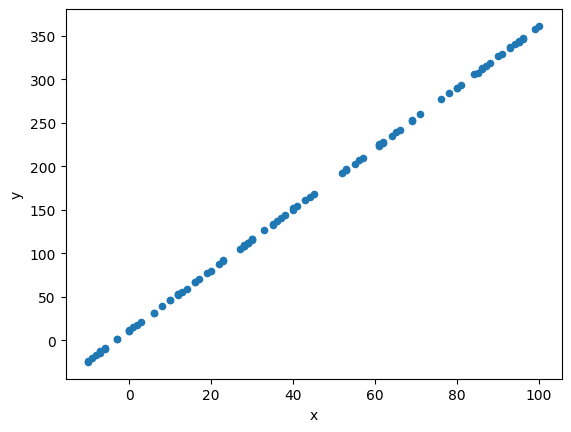

In [23]:
data.plot(x='x', y='y', kind='scatter')